In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression

from scipy.stats import probplot
from sklearn.preprocessing import MinMaxScaler
from numpy import arange
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

import warnings
warnings.simplefilter('ignore')

In [3]:
def calculate_metrics(df, crop_names, y_test, y_pred):
    mae = round(metrics.mean_absolute_error(y_test, y_pred), 3)
    mse = round(metrics.mean_squared_error(y_test, y_pred), 3)
    rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3)
    r2 = round(r2_score(y_test, y_pred), 3)
    y_test_avg = round(pd.DataFrame(y_test).mean().iloc[0], 3)
    y_pred_avg = round(pd.DataFrame(y_pred).mean().iloc[0], 3)
    df.loc[crop_names] = [mae, mse, rmse, r2, y_test_avg, y_pred_avg]


In [4]:
fao_data = pd.read_csv("datasets/latest0705.csv", index_col='Unnamed: 0')

fao_data

,Nutrient nitrogen N (total) - tonnes,Nutrient phosphate P2O5 (total) - tonnes,Nutrient potash K2O (total) - tonnes,Item,Yield(tonnes/ha),Fung & Bact – Benzimidazoles,"Fung & Bact – Diazines, morpholines",Fung & Bact – Dithiocarbamates,Fung & Bact – Inorganics,Fung & Bact – Other,...,Plant Growth Regulators-1,Plant Growth Regulators-2,Rodenticides – Other-1,Rodenticides – Other-2,Herbicides – Bipiridils-1,Herbicides – Bipiridils-2,Herbicides – Sulfonyl ureas-1,Herbicides – Sulfonyl ureas-2,Rodenticides – Anti-coagulants-1,Rodenticides – Anti-coagulants-2
1990-01-01,0.0,0.0,0.0,Apples,26.3272,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Apricots,2.5781,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Cherries,5.0828,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Currants,7.0383,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Gooseberries,6.8081,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01,0.0,0.0,0.0,Mixed grain,-5.8863,0.0,0.0,0.0,0.0,0.0,...,0.0,144.0,0.0,6.0,0.0,-84.0,0.0,4.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Oats,0.8941,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Rye,0.9290,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Triticale,0.4421,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1


In [5]:
fao_data['Category'].value_counts()

Vegetables and Legumes    670
Fruits and Nuts           450
Cereals                   217
Name: Category, dtype: int64

In [6]:
cat_names = fao_data['Category'].unique()
cat_names

array(['Fruits and Nuts', 'Vegetables and Legumes', 'Cereals'],
      dtype=object)

In [7]:
quality_metrics = ['GBR_MAE', 'GBR_MSE', 'GBR_RMSE', 'GBR_r2_score', 'y_test_avg', 'y_pred_avg']
error_df = pd.DataFrame(columns = quality_metrics, index = cat_names)
#display(error_df)

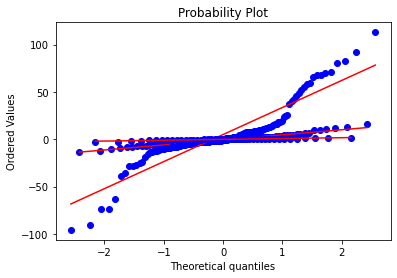

In [18]:
scaler = MinMaxScaler()
for cat in cat_names:
    crop_df = fao_data[fao_data['Category'] == cat]
    encoded_df = pd.get_dummies(crop_df[["Crop_season"]], prefix='', prefix_sep='')

    y = crop_df[['Yield(tonnes/ha)']]
    x = crop_df.drop(['Yield(tonnes/ha)', "Item", "Category", "Crop_season"], axis=1)
    x = pd.concat([x, encoded_df], axis=1)
    

    mean = x.mean()
    std = x.std()
    lower_bound = mean - 2 * std
    upper_bound = mean + 2 * std
    x = x.clip(lower_bound, upper_bound, axis=1)

    x = scaler.fit_transform(x)
  
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
    regressor = GradientBoostingRegressor(n_estimators=500, learning_rate= 0.5)
    regressor.fit(x_train, y_train)


    #prediction of new value
    y_pred = regressor.predict(x_test)

    calculate_metrics(error_df, cat , y_test, y_pred)
    residuals = y_test['Yield(tonnes/ha)'] - regressor.predict(x_test)
    probplot(residuals, dist="norm", plot=plt)
 
    


    
  
    

In [19]:
error_df

,GBR_MAE,GBR_MSE,GBR_RMSE,GBR_r2_score,y_test_avg,y_pred_avg
Fruits and Nuts,4.086,28.797,5.366,0.431,9.623,10.339
Vegetables and Legumes,18.568,950.1,30.824,0.733,45.746,40.836
Cereals,0.671,0.832,0.912,0.857,0.039,0.252
